In [20]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
# import datetime as dt

In [21]:
df = pd.read_excel('../datasets/cleaned_orders.xlsx')
print(df.dtypes)
df.head(2)

Unnamed: 0                                int64
customer_id                               int64
order_time                               object
item_quantity                             int64
item_id                                  object
item_price                              float64
item_discount_raw                       float64
item_discount_percentage                float64
item_disc_bins_item_disc_null             int64
item_disc_bins_item_disc_sub_twenty       int64
item_disc_bins_item_disc_sub_forty        int64
item_disc_bins_item_disc_sub_sixty        int64
item_disc_bins_item_disc_sub_eighty       int64
item_disc_bins_item_disc_sub_hundred      int64
dtype: object


,Unnamed: 0,customer_id,order_time,item_quantity,item_id,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,0,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,0.0,1,0,0,0,0,0
1,1,0,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,0.0,1,0,0,0,0,0


In [22]:
# remove time from datetime so we can groupby later

df.drop(columns=df.columns[0], axis=1, inplace=True)
df['order_time'] = pd.to_datetime(df['order_time']).dt.date
df.head(2)

,customer_id,order_time,item_quantity,item_id,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,2022-04-29,1,Arzuaga blanco,49.0,0.0,0.0,1,0,0,0,0,0
1,0,2022-04-29,1,Arzuaga reserva,94.0,0.0,0.0,1,0,0,0,0,0


In [23]:
df.columns

Index(['customer_id', 'order_time', 'item_quantity', 'item_id', 'item_price',
       'item_discount_raw', 'item_discount_percentage',
       'item_disc_bins_item_disc_null', 'item_disc_bins_item_disc_sub_twenty',
       'item_disc_bins_item_disc_sub_forty',
       'item_disc_bins_item_disc_sub_sixty',
       'item_disc_bins_item_disc_sub_eighty',
       'item_disc_bins_item_disc_sub_hundred'],
      dtype='object')

In [24]:
grouped = df[['order_time', 'item_id', 'item_quantity', 'item_price', 
              'item_disc_bins_item_disc_null', 
              'item_disc_bins_item_disc_sub_twenty',
              'item_disc_bins_item_disc_sub_forty',
              'item_disc_bins_item_disc_sub_sixty',
              'item_disc_bins_item_disc_sub_eighty',
              'item_disc_bins_item_disc_sub_hundred']]

In [25]:
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)


In [32]:
groupedbyitem['item_id'].value_counts()
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']

### Multivariate timeseries analysis using VAR (vector auto regression) - for one wine

In [33]:
sample.sort_values(by='order_time', inplace=True)

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_2140/1515691136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values(by='order_time', inplace=True)


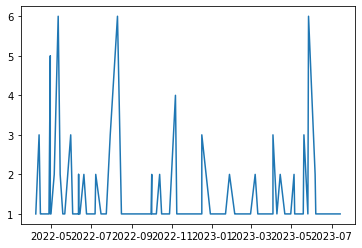

In [37]:
sample['item_id'].value_counts()
x = sample['order_time']
y = sample['item_quantity']
plt.plot(x,y)

In [36]:
sample.head(5)

,order_time,item_id,item_quantity,item_price,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
5026,2022-04-08,Rara Neagră de Purcari 2020,1,47.0,1,0,0,0,0,0
3775,2022-04-08,Rara Neagră de Purcari 2020,1,47.0,1,0,0,0,0,0
22602,2022-04-13,Rara Neagră de Purcari 2020,3,50.0,1,0,0,0,0,0
22552,2022-04-15,Rara Neagră de Purcari 2020,1,50.0,1,0,0,0,0,0
7501,2022-04-16,Rara Neagră de Purcari 2020,1,50.0,1,0,0,0,0,0


In [38]:
# remove the item name
sample.drop(columns=sample.columns[1], axis=1, inplace=True)

# group by order time
#sample = sample.groupby('order_time', group_keys=True).apply(lambda x:x)

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_2140/2963820660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.drop(columns=sample.columns[1], axis=1, inplace=True)


In [39]:
sample.head(5)

,order_time,item_quantity,item_price,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
5026,2022-04-08,1,47.0,1,0,0,0,0,0
3775,2022-04-08,1,47.0,1,0,0,0,0,0
22602,2022-04-13,3,50.0,1,0,0,0,0,0
22552,2022-04-15,1,50.0,1,0,0,0,0,0
7501,2022-04-16,1,50.0,1,0,0,0,0,0


In [40]:
# train 80% and test 20%
train = sample[:int(0.8*(len(sample)))]
test = sample[int(0.8*(len(sample))):]

dates = sample['order_time']
data = sample[['item_quantity', 'item_price',
               'item_disc_bins_item_disc_null', 
               'item_disc_bins_item_disc_sub_twenty',
               'item_disc_bins_item_disc_sub_forty',
               'item_disc_bins_item_disc_sub_sixty',
               'item_disc_bins_item_disc_sub_eighty',
               'item_disc_bins_item_disc_sub_hundred']]

data = data.astype(float)
data.index = pd.DatetimeIndex(dates)

# import VAR model and fit 
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### MLR using sklearn

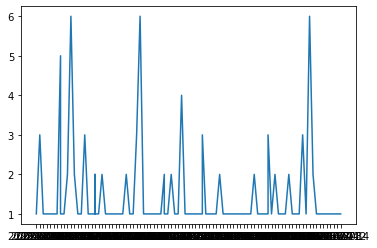

In [44]:
x = sample['order_time'].astype(str)
y = sample['item_quantity']
plt.plot(x,y)

In [45]:
x = sample[['order_time', 'item_price',
               'item_disc_bins_item_disc_null', 
               'item_disc_bins_item_disc_sub_twenty',
               'item_disc_bins_item_disc_sub_forty',
               'item_disc_bins_item_disc_sub_sixty',
               'item_disc_bins_item_disc_sub_eighty',
               'item_disc_bins_item_disc_sub_hundred']]
y = sample['item_quantity']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

TypeError: float() argument must be a string or a number, not 'datetime.date'

In [16]:
y_pred = model.predict(x_test)
y_pred

array([1., 1., 2., 1., 6., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 3.,
       3., 1., 1., 1., 1.])

In [17]:
# evaluating the sklearn model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('mse:' + str(mean_squared_error(y_test,y_pred)))
print('rmse: ' + str(np.sqrt(mean_squared_error(y_test,y_pred))))

r2 score: 1.0
mse:0.0
rmse: 0.0
